In [429]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import pandas as pd
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

import cv2

from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import decode_predictions

In [430]:
def display(images, labels=None):
    plt.figure(figsize=(12, 4))
    n_images = min(5, len(images))
    for i in range(n_images):
        ax = plt.subplot(1, n_images, i + 1)
        plt.imshow(images[i])
        if labels is not None:
            plt.title(labels[i])
        plt.axis("off")

In [431]:
def image_to_array(fn):
    """Load image, cut to square shape and shrink to (224,224,3)"""
    im = Image.open(fn).convert('RGB')
    if im.size[0] > im.size[1]:
        # landscape format -> cut left and right
        xstart = (im.size[0] - im.size[1]) // 2
        im = im.crop((xstart, 0, xstart + im.size[1], im.size[1]))
    else:
        # portrait format -> cut up and down
        ystart = (im.size[1] - im.size[0]) // 2
        im = im.crop((0, ystart, im.size[0], ystart + im.size[0]))
    im = im.resize((224, 224))
    return np.array(im)

In [432]:
cat = image_to_array("images/Cat/1000.jpg")

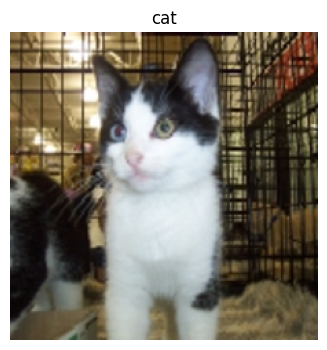

In [433]:
display([cat], ["cat"])

### Testing

In [434]:
m = MobileNet(input_shape=(224, 224, 3))
#CNN - image convolution / convolutional neural network
m.compile()

In [435]:
X = np.vstack(cat).reshape(1, 224, 224, 3)

In [436]:
pred = m.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


In [437]:
decode_predictions(pred)

[[('n04209239', 'shower_curtain', 0.9898323),
  ('n03347037', 'fire_screen', 0.0027840056),
  ('n04418357', 'theater_curtain', 0.0010724681),
  ('n03196217', 'digital_clock', 0.0007066025),
  ('n02666196', 'abacus', 0.0005254937)]]

In [438]:
pred.shape

(1, 1000)

### Base model

In [439]:
base_model = MobileNet(
    include_top=False, # remove the top dense layers
    input_shape=(224,224,3),
    pooling='avg' # average pooling transforms 4d tensor to 2d feature matrix
)

In [440]:
import os

X = []
y = []
for label in os.listdir("images"):
    if label == ".DS_Store": continue
    count = 0
    for filename in os.listdir("images/" + label):
        if filename[-4:].lower() not in (".png", ".jpg"): continue
        if filename == "666.jpg": continue
        X.append(image_to_array("images/" + label + "/" + filename))
        y.append(label)
        count = count + 1
        if count >500: break

# convert X and y into a numpy array
X = np.vstack(X).reshape(len(X), 224, 224, 3)
X = X / 255.0

y = np.array(y)

X.shape, y.shape

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


((1503, 224, 224, 3), (1503,))

In [441]:
#Xfeatures = base_model.predict(X)
#Xfeatures.shape

In [442]:
y

array(['Cat', 'Cat', 'Cat', ..., 'Human', 'Human', 'Human'], dtype='<U5')

### Logistic regression

In [443]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [444]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.7)
Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((450, 224, 224, 3), (1053, 224, 224, 3), (450,), (1053,))

In [445]:
Xtrain_features = base_model.predict(Xtrain)
Xtest_features = base_model.predict(Xtest)
#Xtrain_features = Xtrain.reshape(Xtrain.shape[0], -1)
#Xtest_features = Xtest.reshape(Xtest.shape[0], -1)

15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 495ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 629ms/step


In [446]:
Xtrain_features.shape

(450, 1024)

In [447]:
m = LogisticRegression(max_iter=15000)
m.fit(Xtrain_features, ytrain)

LogisticRegression(max_iter=15000)

In [448]:
ypred_train = m.predict(Xtrain_features)
ypred_test = m.predict(Xtest_features)

In [449]:
accuracy_score(ypred_train, ytrain)

1.0

In [450]:
accuracy_score(ypred_test, ytest).round(4)

0.9934

In [451]:
m.predict_proba(Xtest_features).round(3)

array([[0.036, 0.964, 0.   ],
       [0.   , 0.999, 0.001],
       [0.   , 0.   , 1.   ],
       ...,
       [0.   , 0.001, 0.999],
       [0.999, 0.   , 0.   ],
       [1.   , 0.   , 0.   ]])

In [452]:
from sklearn.model_selection import cross_val_score

cross_val_score(m, Xtrain_features, ytrain, cv=5, scoring="accuracy").round(3)

array([0.978, 0.978, 1.   , 0.978, 0.967])

In [453]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

confusion_matrix(ytest, ypred_test)

array([[362,   2,   0],
       [  5, 324,   0],
       [  0,   0, 360]])

In [454]:
print(classification_report(ytest, ypred_test))

              precision    recall  f1-score   support

         Cat       0.99      0.99      0.99       364
         Dog       0.99      0.98      0.99       329
       Human       1.00      1.00      1.00       360

    accuracy                           0.99      1053
   macro avg       0.99      0.99      0.99      1053
weighted avg       0.99      0.99      0.99      1053



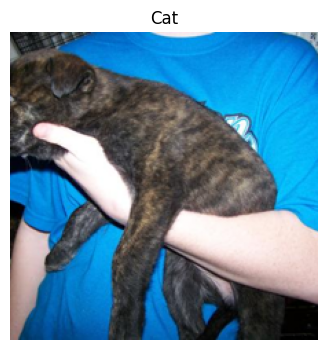

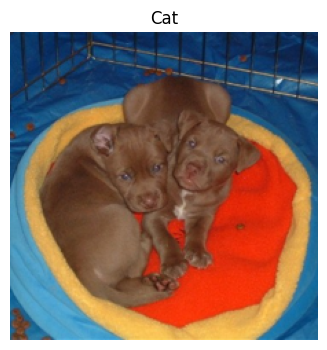

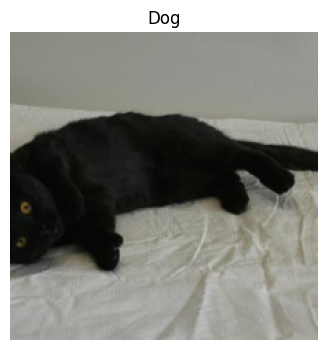

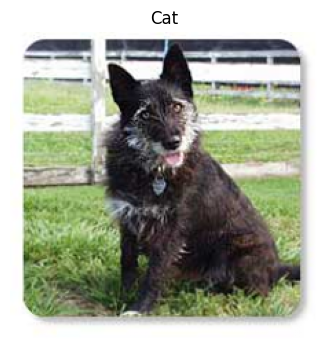

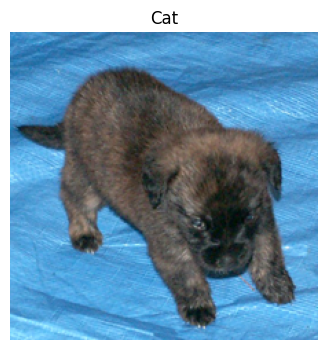

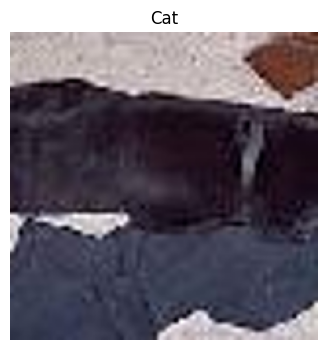

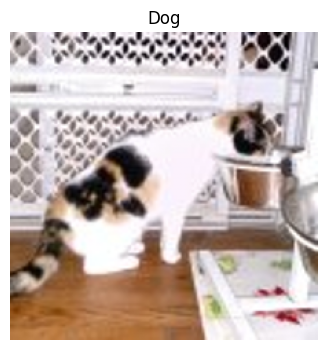

In [455]:
count = 0
for i in range(0, ypred_test.size):
    if ytest[i] != ypred_test[i]:
        display([Xtest[i]], [ypred_test[i]])
        count = count +1
        if count > 19: 
            break

In [456]:
count = 0
for i in range(0, ypred_test.size):
    if ytest[i] != ypred_test[i]:
        print(m.predict_proba([Xtest_features[i]]).round(3))
        count = count +1
        if count > 19: 
            break

[[0.734 0.266 0.   ]]
[[0.519 0.481 0.   ]]
[[0.274 0.726 0.   ]]
[[0.767 0.23  0.003]]
[[0.889 0.11  0.   ]]
[[0.973 0.026 0.001]]
[[0.438 0.562 0.001]]


In [457]:
img = image_to_array("images/Cat/3000.jpg")
X = np.vstack(cat).reshape(1, 224, 224, 3)
X = X / 255.0
pred = base_model.predict(X)
pred = m.predict(pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


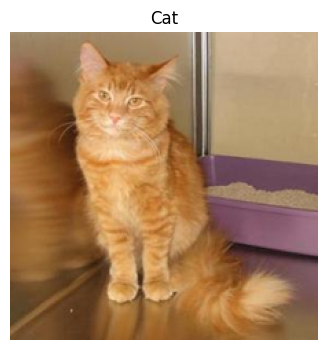

In [458]:
display([Xtest[42]], [ytest[42]])

In [459]:
import pickle

spickle.dump(m, open("cat_or_dog.pckl", "wb"))

@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
title = {Asirra: A CAPTCHA that Exploits Interest-Aligned Manual Image Categorization},
booktitle = {Proceedings of 14th ACM Conference on Computer and Communications Security (CCS)},
year = {2007},
month = {October},
publisher = {Association for Computing Machinery, Inc.},
url = {https://www.microsoft.com/en-us/research/publication/asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization/},
edition = {Proceedings of 14th ACM Conference on Computer and Communications Security (CCS)},
}

@inproceedings{liu2015faceattributes,
  title = {Deep Learning Face Attributes in the Wild},
  author = {Liu, Ziwei and Luo, Ping and Wang, Xiaogang and Tang, Xiaoou},
  booktitle = {Proceedings of International Conference on Computer Vision (ICCV)},
  month = {December},
  year = {2015} 
}